In [25]:
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import math
from functools import reduce
import random
%matplotlib inline
np.random.seed(42)

In [2]:
def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [3]:
X_train, Y_train, X_test, Y_test = load()

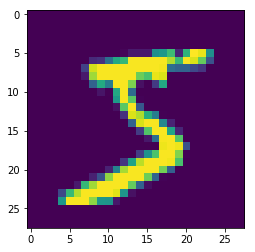

In [4]:
plt.imshow(X_train[0].reshape(28,28))

In [100]:
class FC:
    def __init__(self, in_channel, out_channel):
        self.W = {'val': np.random.standard_normal((in_channel,out_channel)), 'grad': 0}
        self.b = {'val': np.random.randn(out_channel), 'grad': 0}
        self.cache = None
    
    def forward(self, X):
        out = np.dot(X, self.W['val']) + self.b['val']
        self.cache = X
        return out
    
    def backward(self, dout):
        X = self.cache
        dX = np.dot(dout, self.W['val'].T).reshape(X.shape)
        self.W['grad'] = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, dout)
        self.b['grad'] = np.sum(dout, axis=0)
#         self.update()
        return dX
    
    def update(self, lr=0.001):
        self.W['val'] -= lr*self.W['grad']
        self.b['val'] -= lr*self.b['grad']

In [131]:
class Conv2d():
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, init_params=False):
        """
        :param in_channels: (int) the input channel
        :param out_channels: (int) the output channel
        :param kernel_size: (int) the kernel size
        :param stride: (int) the stirde
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.input_h = None
        self.input_w = None
        self.out_h = None
        self.out_w = None

        self.weight_gradient = 0
        self.bias_gradient = 0

        self.init_params = init_params

        self.W = {'val': np.random.randn(self.in_channels, self.out_channels, self.kernel_size, self.kernel_size), 'grad': 0}
        self.b = {'val': np.random.randn(self.out_channels, 1), 'grad': 0}


        # 输入图像的batch_size=N，默认为1
        self.batch_size = 1



    def forward(self, x):
        """
        :param x: (N, C_in, H_in, W_in) 通道*高度*宽度
        :return: 
        """
        self.input_map = x

        if not self.init_params:
            self.init_params = True
            weights_scale = math.sqrt(reduce(lambda x, y: x * y, self.input_map.shape) / self.out_channels)

            self.W['val'] = np.random.standard_normal(
                size=(self.in_channels, self.out_channels, self.kernel_size, self.kernel_size)) / weights_scale
            self.b['val'] = np.random.standard_normal(size=(self.out_channels, 1)) / weights_scale

        self.batch_size, _, self.input_h, self.input_w = x.shape

        self.out_h = int((self.input_h-self.kernel_size)/self.stride + 1)
        self.out_w = int((self.input_w-self.kernel_size)/self.stride + 1)
        # print('out_h:', self.out_h)
        # print('out_w:', self.out_w)

        # 图像转换为矩阵，N*(H*W)*(C*K*K)
        self.col_images = []

        weight_col = self.W['val'].reshape(self.out_channels, -1)
        # N * C_out * H_out * W_out
        conv_out = np.zeros((self.batch_size, self.out_channels, self.out_h, self.out_w))
        for batch_i in range(self.batch_size):
            # 输入的第i个图像C_in*H_in*W_in
            image_batch_i = x[batch_i, :]
            image_batch_i_col = self.im2col(image_batch_i, self.kernel_size, self.stride)

            self.col_images.append(image_batch_i_col)
            # print(image_batch_i_col.shape)
            # print(weight_col.shape)
            conv_out[batch_i] = np.reshape(np.dot(weight_col, np.transpose(image_batch_i_col))+self.b['val'], (self.out_channels, self.out_h, self.out_w))

        self.col_images = np.array(self.col_images)

        return conv_out

    # 计算梯度过程中同时将误差反向传播计算出来，根据当前误差返回上一误差
    def backward(self, error):
        self.error = error
        error_col = self.error.reshape(self.batch_size, self.out_channels, -1)
        # print('self.col_images.shape:', self.col_images.shape)
        # print('error_col.shape:', error_col.shape)
        # print('error.shape:', error.shape)

        for batch_i in range(self.batch_size):
            self.W['grad'] += np.dot(error_col[batch_i], self.col_images[batch_i]).reshape(self.W['val'].shape)
        # 将对应的维度相加，需要将N和最后求和
        self.b['grad'] += np.sum(error_col, axis=(0, 2)).reshape(self.b['val'].shape)
        # 反向传播计算上一层error

        error_pad = np.pad(self.error, ((0, 0), (0, 0), (self.kernel_size - 1, self.kernel_size - 1), (self.kernel_size - 1, self.kernel_size - 1)), 'constant', constant_values=0)
        # print('error_pad.shape:', error_pad.shape)
        # print('error:', error)
        # print('error_pad:', error_pad)

        weight_flip = self.W['val'][:, :, ::-1, ::-1]
        weight_flip = np.swapaxes(weight_flip, 0, 1)
        weight_flip_col = weight_flip.reshape(self.in_channels, -1)
        # print('weight_flip_col.shape:', weight_flip_col.shape)


        next_error = np.zeros((self.batch_size, self.in_channels, self.input_h, self.input_w))
        for batch_i in range(self.batch_size):
            # 输入的第i个图像C_in*H_in*W_in
            error_pad_image_batch_i = error_pad[batch_i, :]
            error_pad_image_batch_i_col = self.im2col(error_pad_image_batch_i, self.kernel_size, self.stride)
            # print('error_pad_image_batch_i_col.shape:', error_pad_image_batch_i_col.shape)
            next_error[batch_i] = np.reshape(np.dot(weight_flip_col, np.transpose(error_pad_image_batch_i_col)), (self.in_channels, self.input_h, self.input_w))


        return next_error
    
    def im2col(self, image, ksize, stride):
        # image is a 3d tensor([channel, height, width])
        image_col = []
        for i in range(0, image.shape[1] - ksize + 1, stride):
            for j in range(0, image.shape[2] - ksize + 1, stride):
                col = image[:,i:i + ksize, j:j + ksize].reshape([-1])
                image_col.append(col)
        image_col = np.array(image_col)
        return image_col

In [124]:
class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size,kernel_size,in_channels,out_channels)
        self.stride = stride
        self.cache = 0
        
        self.W = {'val': np.random.standard_normal((self.kernel_size)), 'grad': np.zeros(self.kernel_size)}
        self.b = {'val': np.random.standard_normal(out_channels), 'grad': np.zeros(out_channels)}
        
    def forward(self, x):
        (N,Cin,H,W) = x.shape
        self.input_shape = x.shape
        H_ = int((H - self.kernel_size[0]) / self.stride + 1)
        W_ = int((W - self.kernel_size[0]) / self.stride + 1)
        col_weights = self.W['val'].reshape([-1,self.out_channels])
        self.col_image = []
        conv_out = np.zeros((N,self.out_channels,H_,W_))
        for i in range(N):
            img_i = x[i]
            self.col_image_i = self.im2col(img_i,self.kernel_size[0],self.stride)
#             print(self.col_image_i.shape)
            conv_out[i] = np.reshape(np.dot(self.col_image_i, col_weights) + self.b['val'],(H_,W_,-1)).transpose(2,0,1)
            self.col_image.append(self.col_image_i)
        self.col_image = np.array(self.col_image)
        return conv_out
    
    def backward(self, dout):
        (N,Cout,H_,W_) = dout.shape
        col_dout = dout.reshape((N,Cout,-1))
        
        for i in range(self.input_shape[0]):
            self.W['grad'] += np.dot(col_dout[i], self.col_image[i]).reshape(self.W['val'].shape)
        self.b['grad'] += np.sum(col_dout,axis=(0,2)).reshape(self.b['val'].shape)
        
        dout_pad = np.pad(dout, ((0, 0), (0, 0), (self.kernel_size[0] - 1, self.kernel_size[0] - 1), (self.kernel_size[0] - 1, self.kernel_size[0] - 1)), 'constant', constant_values=0)
        
        weight_flip = self.W['val'][:,:,::-1,::-1]
        weight_flip = np.swapaxes(weight_flip, 0, 1)
        weight_flip_col = weight_flip.reshape(self.in_channels, -1)
        
        next_dout =  np.zeros((N, self.in_channels, self.input_shape[2], self.input_shape[3]))
        for i in range(N):
            dout_pad_image_batch_i = dout_pad[i,:]
            dout_pad_image_batch_i_col = self.im2col(dout_pad_image_batch_i , self.kernel_size[0], self.stride)
            next_dout[i] = np.reshape(np.dot(weight_flip_col, np.transpose(dout_pad_image_batch_i_col)), (self.in_channels, self.input_shape[2], self.input_shape[3]))
        
        return next_dout
        
    def im2col(self, image, ksize, stride):
        # image is a 3d tensor([channel, height, width])
        image_col = []
        for i in range(0, image.shape[1] - ksize + 1, stride):
            for j in range(0, image.shape[2] - ksize + 1, stride):
                col = image[:,i:i + ksize, j:j + ksize].reshape([-1])
                image_col.append(col)
        image_col = np.array(image_col)
        return image_col

In [7]:
class MaxPool2d:
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride
        self.mask = 0
    
    def forward(self, x):
        (N,Cin,H,W) = x.shape
        H_ = int(H/self.kernel_size)
        W_ = int(W/self.kernel_size)
        out = np.zeros((N, Cin, H_, W_))
        self.mask = np.zeros(x.shape)
        for n in range(N):
            for cin in range(Cin):
                for h in range(0, H, self.stride):
                    for w in range(0, W, self.stride):
                        out[n,cin,h//self.stride,w//self.stride] = np.max(x[n,cin,h:h + self.kernel_size, w:w + self.kernel_size])
                        i,j = np.unravel_index(np.argmax(x[n,cin,h:h + self.kernel_size, w:w + self.kernel_size]),(self.kernel_size,self.kernel_size))
                        self.mask[n,cin,i+h,j+w] = 1
        return out
    
    def backward(self,dout):
        return np.repeat(np.repeat(dout, self.stride, axis=2), self.stride, axis=3) * self.mask

In [65]:
class Softmax():
    def __init__(self):
        self.cache = None
        self.loss = 0
        
    def forward(self, prediction):
        self.prediction = prediction
        exp_prediction = np.zeros(prediction.shape)
        self.softmax = np.zeros(prediction.shape)
        for n in range(prediction.shape[0]):
            prediction[n, :] -= np.max(prediction[n, :]) # 防止上溢出
            exp_prediction[n] = np.exp(prediction[n])
            self.softmax[n] = exp_prediction[n]/np.sum(exp_prediction[n])
    
        return self.softmax
    
    def backward(self):
        pass

In [77]:
class NLLLoss():
    def __init__(self):
        self.loss = 0
    
    def forward(self, pred, target):
        loss = 0.0
        N = pred.shape[0]
        for n in range(N):
            label = target[n]
            if pred[n,label] == 0:
                loss += 500
            else:
                self.loss += -np.log(pred[n,label])
        return self.loss / N
        
    def backward(self):
        pass

In [78]:
class CrossEntropyLoss():
    def __init__(self):
        pass
    
    def get(self, Y_pred, Y_true):
        N = Y_pred.shape[0]
        softmax = Softmax()
        nllLoss = NLLLoss()
        prob = softmax.forward(Y_pred)
        loss = nllLoss.forward(prob, Y_true)
        dout = prob.copy()
        dout[np.arange(N), Y_true] -= 1
        return loss, dout

In [68]:
class ReLU():
    """
    ReLU activation layer
    """
    def __init__(self):
        #print("Build ReLU")
        self.cache = None

    def forward(self, X):
        #print("ReLU: _forward")
        out = np.maximum(0, X)
        self.cache = X
        return out

    def backward(self, dout):
        #print("ReLU: _backward")
        X = self.cache
        dX = np.array(dout, copy=True)
        dX[X <= 0] = 0
        return dX

In [69]:
class Dropout():
    """
    Dropout layer
    """
    def __init__(self, p=1):
        self.cache = None
        self.p = p

    def forward(self, X):
        M = (np.random.rand(*X.shape) < self.p) / self.p
        self.cache = X, M
        return X*M

    def backward(self, dout):
        X, M = self.cache
        dX = dout*M/self.p
        return dX

In [84]:
class SGD():
    def __init__(self, params, lr=0.001, reg=0):
        self.parameters = params
        self.lr = lr
        self.reg = reg

    def step(self):
        for param in self.parameters:
            param['val'] -= (self.lr*param['grad'] + self.reg*param['val'])

In [127]:
class SGDMomentum():
    def __init__(self, params, lr=0.001, momentum=0.99, reg=0):
        self.l = len(params)
        self.parameters = params
        self.velocities = []
        for param in self.parameters:
            self.velocities.append(np.zeros(param['val'].shape))
        self.lr = lr
        self.rho = momentum
        self.reg = reg

    def step(self):
        for i in range(self.l):
            self.velocities[i] = self.rho*self.velocities[i] + (1-self.rho)*self.parameters[i]['grad']
            self.parameters[i]['val'] -= (self.lr*self.velocities[i] + self.reg*self.parameters[i]['val'])

In [132]:
class LeNet5():
    def __init__(self):
        self.conv1 = Conv2d(1, 6, 5)
        self.ReLU1 = ReLU()
        self.pool1 = MaxPool2d(2,2)
        self.conv2 = Conv2d(6, 16, 5)
        self.ReLU2 = ReLU()
        self.pool2 = MaxPool2d(2,2)
        self.FC1 = FC(16*4*4, 120)
        self.ReLU3 = ReLU()
        self.FC2 = FC(120, 84)
        self.ReLU4 = ReLU()
        self.FC3 = FC(84, 10)

        self.p2_shape = None
        
    def forward(self, X):
        h1 = self.conv1.forward(X)
        a1 = self.ReLU1.forward(h1)
        p1 = self.pool1.forward(a1)
        h2 = self.conv2.forward(p1)
        a2 = self.ReLU2.forward(h2)
        p2 = self.pool2.forward(a2)
        self.p2_shape = p2.shape
        fl = p2.reshape(X.shape[0],-1) # Flatten
        h3 = self.FC1.forward(fl)
        a3 = self.ReLU3.forward(h3)
        h4 = self.FC2.forward(a3)
        a5 = self.ReLU4.forward(h4)
        h5 = self.FC3.forward(a5)
        return h5
    
    def backward(self, dout):
        dout = self.FC3.backward(dout)
        dout = self.ReLU4.backward(dout)
        dout = self.FC2.backward(dout)
        dout = self.ReLU3.backward(dout)
        dout = self.FC1.backward(dout)
        dout = dout.reshape(self.p2_shape) # reshape
        dout = self.pool2.backward(dout)
        dout = self.ReLU2.backward(dout)
        dout = self.conv2.backward(dout)
        dout = self.pool1.backward(dout)
        dout = self.ReLU1.backward(dout)
        dout = self.conv1.backward(dout)
        
    def get_params(self):
        return [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params

In [133]:
def get_batch(X, Y, batch_size):
    N = len(X)
    i = random.randint(1, N-batch_size)
    return X[i:i+batch_size], Y[i:i+batch_size]

In [134]:
X_train, Y_train, X_test, Y_test = load()
X_train, X_test = X_train/float(255), X_test/float(255)
X_train -= np.mean(X_train)
X_test -= np.mean(X_test)

In [139]:
model = LeNet5()
losses = []
optim = SGDMomentum(model.get_params(), lr=0.0001, momentum=0.80, reg=0.00003)
criterion = CrossEntropyLoss()

In [140]:
batch_size = 16

In [141]:
ITER = 25000
for i in range(ITER):
    # get batch, make onehot
    X_batch, Y_batch = get_batch(X_train, Y_train, batch_size)

    # forward, loss, backward, step
    X_batch = X_batch.reshape((batch_size, 1, 28, 28))
    Y_pred = model.forward(X_batch)
#     print(Y_pred)
    loss, dout = criterion.get(Y_pred, Y_batch)
#     print(dout)
    model.backward(dout)
    optim.step()

    if i % 100 == 0:
        print("%s%% iter: %s, loss: %s" % (100*i/ITER,i, loss))
        losses.append(loss)

0.0% iter: 0, loss: 41.4633023728112
0.4% iter: 100, loss: 2.3412491573794174
0.8% iter: 200, loss: 2.3035299930947026
1.2% iter: 300, loss: 2.5868564395210836
1.6% iter: 400, loss: 2.3145510668052163
2.0% iter: 500, loss: 2.3653973036309646
2.4% iter: 600, loss: 2.326368302701193
2.8% iter: 700, loss: 2.3943870316200835
3.2% iter: 800, loss: 2.3214183206224988
3.6% iter: 900, loss: 2.6561853775115285
4.0% iter: 1000, loss: 2.300080458085136
4.4% iter: 1100, loss: 2.3646496458984996
4.8% iter: 1200, loss: 2.436741560898203
5.2% iter: 1300, loss: 2.2166945777290255
5.6% iter: 1400, loss: 2.2846001574782635
6.0% iter: 1500, loss: 2.4481147328962214
6.4% iter: 1600, loss: 2.282667533696766
6.8% iter: 1700, loss: 2.4470688146979103
7.2% iter: 1800, loss: 2.429213668543574
7.6% iter: 1900, loss: 2.319323173972759
8.0% iter: 2000, loss: 2.4317727654849333
8.4% iter: 2100, loss: 2.3924391044026754
8.8% iter: 2200, loss: 2.314277452229027
9.2% iter: 2300, loss: 2.3479829450615597
9.6% iter: 24

In [49]:
batch = X_train[0:2].reshape(2,1,28,28)

In [50]:
conv2d = Conv2d(1,6,5)
out = conv2d.forward(batch)
out.shape

(576, 25)
(576, 25)


(2, 6, 24, 24)

In [51]:
real = out.copy() + 1

In [52]:
dout = conv2d.backward(real-out)

In [53]:
dout

array([[[[ -5.60940891, -10.83559184, -10.82332433, ...,  -0.57075499,
           -0.5830225 ,   0.97290732],
         [ -8.84154755, -18.74743301, -20.49830635, ...,  -1.93744294,
           -0.1865696 ,   0.78923514],
         [-12.66774302, -20.3079634 , -23.26653143, ...,   0.06372398,
            3.02229201,   0.48989108],
         ...,
         [ -0.13819793,   2.60949862,   1.72871981, ...,   5.86016799,
            6.7409468 ,  -1.06757788],
         [  3.68799755,   4.17002901,   4.49694489, ...,   3.85900107,
            3.5320852 ,  -0.76823382],
         [ -0.19715702,   0.70554064,   1.61050725, ...,   1.68101308,
            0.77604646,  -0.6356793 ]]],


       [[[ -5.60940891, -10.83559184, -10.82332433, ...,  -0.57075499,
           -0.5830225 ,   0.97290732],
         [ -8.84154755, -18.74743301, -20.49830635, ...,  -1.93744294,
           -0.1865696 ,   0.78923514],
         [-12.66774302, -20.3079634 , -23.26653143, ...,   0.06372398,
            3.02229201,   0.489

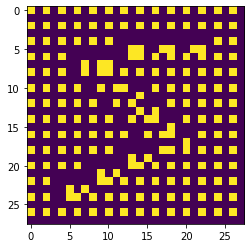

In [52]:
pool2d = MaxPool2d()
out = pool2d.forward(batch)
plt.imshow(pool2d.mask[0].reshape(28,28))

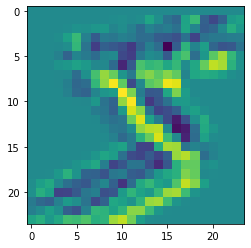

In [9]:
plt.imshow(out[0,0,:,:].reshape(24,24))